In [20]:
# ============================================================
# Environment setup
# ============================================================
from __future__ import annotations

import os
import sys
from pathlib import Path
from typing import Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

try:
    from IPython.display import display
except ImportError:  
    display = print 

# ----------------------------
# Reproducibility
# ----------------------------
RNG_SEED: int = 42

np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
torch.cuda.manual_seed_all(RNG_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----------------------------
# Paths
# ----------------------------

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATASET_DIR = PROJECT_ROOT / "data/dataset.csv"
MODELS_DIR = PROJECT_ROOT / "models"
PYTHON_DIR = PROJECT_ROOT / "python"

MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Make local python/ package importable
if str(PYTHON_DIR) not in sys.path:
    sys.path.append(str(PYTHON_DIR))

# ----------------------------
# Device
# ----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv(
    DATASET_DIR,
    low_memory=False,  # Using full-file type inference instead of chunk-based
)
# Strip whitespace from all column names
df.columns = df.columns.str.strip()

In [3]:
# ----------------------------
# Quick Inspect Data
# ----------------------------
def quick_inspect_data(df: pd.DataFrame) -> None:
    print(f"Shapes: {df.shape}")

    print("Columns: ")
    print(df.columns.tolist(), "\n")

    print("First rows: ")
    display(df.head())
    print("Info about the dataset: ")
    print(df.info())
quick_inspect_data(df)

Shapes: (299695, 17)
Columns: 
['transaction_id', 'user_id', 'account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'country', 'bin_country', 'channel', 'merchant_category', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'transaction_time', 'shipping_distance_km', 'is_fraud'] 

First rows: 


,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


Info about the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 no

In [4]:
# ============================================================
# Train / Validation / Test split (stratified, no helpers)
# ============================================================

TARGET_COL: str = "is_fraud"

# Using a clean working copy without raw ID column.
df_model = df.drop(columns=["transaction_id"])

# Using X_df as features and y_df as target.
X_df = df_model.drop(columns=[TARGET_COL])
y_df = df_model[TARGET_COL]

# ----------------------------
# take 15% of full data as validation (stratified)
# ----------------------------
X_train_temp, X_val, y_train_temp, y_val = train_test_split(
    X_df,
    y_df,
    test_size=0.15,          # 15% global -> validation
    stratify=y_df,
    random_state=RNG_SEED,
    shuffle=True,
)

# ----------------------------
# split remaining into train / test (stratified)
# To get 15% test globally:
# remaining = 1 - 0.15 = 0.85
# test_size_rel = 0.15 / 0.85 ≈ 0.17647
# ----------------------------
test_size_rel = 0.15 / 0.85

X_train, X_test, y_train, y_test = train_test_split(
    X_train_temp,
    y_train_temp,
    test_size=test_size_rel,
    stratify=y_train_temp,
    random_state=RNG_SEED,
    shuffle=True,
)

# ----------------------------
# Sanity check: shapes + class balance
# ----------------------------
def _fraud_ratio(y):
    return float((y == 1).mean() * 100.0)


n_total = len(y_df)

print("Split shapes:")
print(f"  Train: {X_train.shape[0]} rows")
print(f"  Val:   {X_val.shape[0]} rows")
print(f"  Test:  {X_test.shape[0]} rows")

print("\nSplit percentages (of full data):")
print(f"  Train: {X_train.shape[0] / n_total * 100:.2f}%")
print(f"  Val:   {X_val.shape[0] / n_total * 100:.2f}%")
print(f"  Test:  {X_test.shape[0] / n_total * 100:.2f}%")

print("\nFraud ratio per split:")
print(f"  Full:  {_fraud_ratio(y_df):5.2f}%")
print(f"  Train: {_fraud_ratio(y_train):5.2f}%")
print(f"  Val:   {_fraud_ratio(y_val):5.2f}%")
print(f"  Test:  {_fraud_ratio(y_test):5.2f}%")


Split shapes:
  Train: 209785 rows
  Val:   44955 rows
  Test:  44955 rows

Split percentages (of full data):
  Train: 70.00%
  Val:   15.00%
  Test:  15.00%

Fraud ratio per split:
  Full:   2.21%
  Train:  2.21%
  Val:    2.21%
  Test:   2.21%


In [5]:
print(f"train data shape X: {X_train.shape} , shape y: {y_train.shape}")
display(X_train.head(5))
X_train.info()

train data shape X: (209785, 15) , shape y: (209785,)


,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km
33273,668,869,57,405.04,363.85,NL,TR,web,grocery,0,1,1,1,2024-06-03T08:21:36Z,943.93
25170,507,928,42,49.78,147.58,RO,RO,app,grocery,0,1,0,0,2024-01-07T20:04:48Z,442.90
37254,748,1314,58,42.29,28.01,NL,NL,web,gaming,0,1,1,1,2024-08-21T14:51:02Z,9.85
239229,4793,1232,44,80.27,95.53,NL,NL,app,travel,0,0,1,1,2024-10-18T11:18:55Z,116.42
18836,379,1741,42,804.16,1016.36,IT,IT,web,travel,0,0,1,1,2024-01-03T04:14:06Z,429.14


<class 'pandas.core.frame.DataFrame'>
Index: 209785 entries, 33273 to 105894
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  209785 non-null  int64  
 1   account_age_days         209785 non-null  int64  
 2   total_transactions_user  209785 non-null  int64  
 3   avg_amount_user          209785 non-null  float64
 4   amount                   209785 non-null  float64
 5   country                  209785 non-null  object 
 6   bin_country              209785 non-null  object 
 7   channel                  209785 non-null  object 
 8   merchant_category        209785 non-null  object 
 9   promo_used               209785 non-null  int64  
 10  avs_match                209785 non-null  int64  
 11  cvv_result               209785 non-null  int64  
 12  three_ds_flag            209785 non-null  int64  
 13  transaction_time         209785 non-null  object 
 14  shipp

In [6]:
# ============================================================
# Categorical encoding with OneHotEncoder
# ============================================================

# Columns for one-hot encoding
CATEGORICAL_OHE_COLS = ["country", "bin_country", "merchant_category"]

# Binary encoding for 'channel'
CHANNEL_COL = "channel"
CHANNEL_MAPPING = {"web": 0, "app": 1}

# ----------------------------
# Copy splits to avoid side effects
# ----------------------------
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
X_test_enc = X_test.copy()

# ----------------------------
# Encode 'channel' as binary feature (fixed mapping)
# ----------------------------
for df_split in (X_train_enc, X_val_enc, X_test_enc):
    df_split[CHANNEL_COL] = (df_split[CHANNEL_COL].map(CHANNEL_MAPPING).astype("int8"))

# ----------------------------
# Fit OneHotEncoder on train categorical columns
# ----------------------------
ohe = OneHotEncoder(
    handle_unknown="ignore",  # Using ignore to safely handle unseen categories in val/test
    sparse_output=False, # to get numpy array
    dtype=np.int8
)

ohe.fit(X_train_enc[CATEGORICAL_OHE_COLS])

ohe_feature_names = ohe.get_feature_names_out(CATEGORICAL_OHE_COLS)

# ----------------------------
# Transform each split and rebuild clean feature matrices
# ----------------------------
def build_encoded_frame(
    X_source: pd.DataFrame,
    encoder: OneHotEncoder,
    cat_cols: list,
    ohe_feature_names: np.ndarray,
) -> pd.DataFrame:
    """
    Build a fully encoded feature DataFrame for a given split.

    Using:
        - A fitted OneHotEncoder on the training categorical columns.
        - Numeric and already-encoded columns kept as-is.
        - One-hot encoded columns concatenated as dense features.

    Returns:
        Encoded DataFrame with aligned schema.
    """
    # One-hot encode categorical subset
    cat_ohe = encoder.transform(X_source[cat_cols])

    # Numeric + non-OHE columns (everything except categorical OHE cols)
    X_num = X_source.drop(columns=cat_cols)

    # Combine numeric and one-hot encoded features
    X_encoded = pd.concat(
        [
            X_num.reset_index(drop=True),
            pd.DataFrame(cat_ohe, columns=ohe_feature_names),
        ],
        axis=1,
    )

    return X_encoded


X_train_encoded = build_encoded_frame(
    X_source=X_train_enc,
    encoder=ohe,
    cat_cols=CATEGORICAL_OHE_COLS,
    ohe_feature_names=ohe_feature_names,
)

X_val_encoded = build_encoded_frame(
    X_source=X_val_enc,
    encoder=ohe,
    cat_cols=CATEGORICAL_OHE_COLS,
    ohe_feature_names=ohe_feature_names,
)

X_test_encoded = build_encoded_frame(
    X_source=X_test_enc,
    encoder=ohe,
    cat_cols=CATEGORICAL_OHE_COLS,
    ohe_feature_names=ohe_feature_names,
)

# ----------------------------
# Quick schema check
# ----------------------------
print("Encoded shapes:")
print(f"  X_train_encoded: {X_train_encoded.shape}")
print(f"  X_val_encoded:   {X_val_encoded.shape}")
print(f"  X_test_encoded:  {X_test_encoded.shape}")


Encoded shapes:
  X_train_encoded: (209785, 37)
  X_val_encoded:   (44955, 37)
  X_test_encoded:  (44955, 37)


In [7]:
X_train_encoded["transaction_time"].head(10)

0    2024-06-03T08:21:36Z
1    2024-01-07T20:04:48Z
2    2024-08-21T14:51:02Z
3    2024-10-18T11:18:55Z
4    2024-01-03T04:14:06Z
5    2024-07-27T15:16:36Z
6    2024-01-26T23:01:59Z
7    2024-10-22T11:24:01Z
8    2024-09-21T19:47:41Z
9    2024-09-23T05:48:17Z
Name: transaction_time, dtype: object

In [8]:
# ============================================================
# Datetime feature engineering for transaction_time
# ============================================================

def add_transaction_time_features(
    df: pd.DataFrame,
    col: str = "transaction_time",
) -> pd.DataFrame:
    """
    Expand the transaction datetime column into meaningful numerical features.

    Using:
        - pandas.to_datetime to parse ISO8601 timestamps.
        - Calendar components (year, month, day, hour, minute, weekday).
        - Weekend indicator.
        - Cyclic encodings for hour-of-day and day-of-week.

    The original datetime column is dropped after feature extraction.
    """
    # Work on a copy to avoid mutating external references.
    df = df.copy()

    # Parse timestamps (with UTC awareness, 'Z' suffix is UTC)
    dt = pd.to_datetime(df[col], errors="coerce", utc=True)

    # Basic calendar components
    df["tx_year"] = dt.dt.year.astype("int16")
    df["tx_month"] = dt.dt.month.astype("int8")
    df["tx_day"] = dt.dt.day.astype("int8")
    df["tx_hour"] = dt.dt.hour.astype("int8")
    df["tx_minute"] = dt.dt.minute.astype("int8")
    df["tx_dayofweek"] = dt.dt.dayofweek.astype("int8")  # 0 = Monday, 6 = Sunday

    # Weekend flag
    df["tx_is_weekend"] = (df["tx_dayofweek"] >= 5).astype("int8")

    # Cyclic encoding for hour of day (24h)
    df["tx_hour_sin"] = np.sin(2 * np.pi * df["tx_hour"] / 24)
    df["tx_hour_cos"] = np.cos(2 * np.pi * df["tx_hour"] / 24)

    # Cyclic encoding for day of week (7d)
    df["tx_dow_sin"] = np.sin(2 * np.pi * df["tx_dayofweek"] / 7)
    df["tx_dow_cos"] = np.cos(2 * np.pi * df["tx_dayofweek"] / 7)

    # Drop raw datetime column to keep only numerical features
    df = df.drop(columns=[col])

    return df


# ----------------------------
# Apply to all encoded splits
# ----------------------------
X_train_encoded = add_transaction_time_features(X_train_encoded, col="transaction_time")
X_val_encoded = add_transaction_time_features(X_val_encoded, col="transaction_time")
X_test_encoded = add_transaction_time_features(X_test_encoded, col="transaction_time")

print("After datetime features:")
print(f"  X_train_encoded: {X_train_encoded.shape}")
print(f"  X_val_encoded:   {X_val_encoded.shape}")
print(f"  X_test_encoded:  {X_test_encoded.shape}")


After datetime features:
  X_train_encoded: (209785, 47)
  X_val_encoded:   (44955, 47)
  X_test_encoded:  (44955, 47)


In [9]:
# ============================================================
# Drop redundant/raw datetime components
# ============================================================

DROP_TIME_COLS = [
    "tx_year",        # Constant (2024) in this dataset, not informative
    "tx_day",         # Day-of-month, usually weak signal here
    "tx_hour",        # Replaced by tx_hour_sin / tx_hour_cos
    "tx_dayofweek",   # Replaced by tx_dow_sin / tx_dow_cos
    "tx_minute",      # Optional: removing to reduce noise / sparsity
]

X_train_encoded = X_train_encoded.drop(columns=DROP_TIME_COLS)
X_val_encoded = X_val_encoded.drop(columns=DROP_TIME_COLS)
X_test_encoded = X_test_encoded.drop(columns=DROP_TIME_COLS)

print("After dropping raw datetime cols:")
print(f"  X_train_encoded: {X_train_encoded.shape}")
print(f"  X_val_encoded:   {X_val_encoded.shape}")
print(f"  X_test_encoded:  {X_test_encoded.shape}")


After dropping raw datetime cols:
  X_train_encoded: (209785, 42)
  X_val_encoded:   (44955, 42)
  X_test_encoded:  (44955, 42)


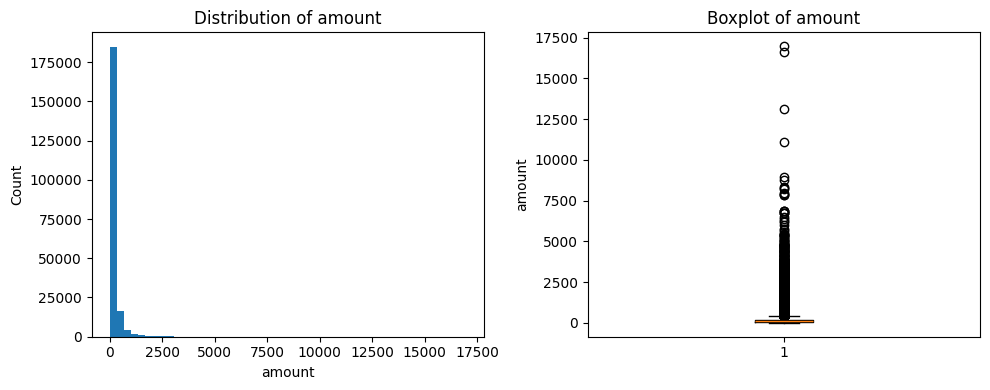

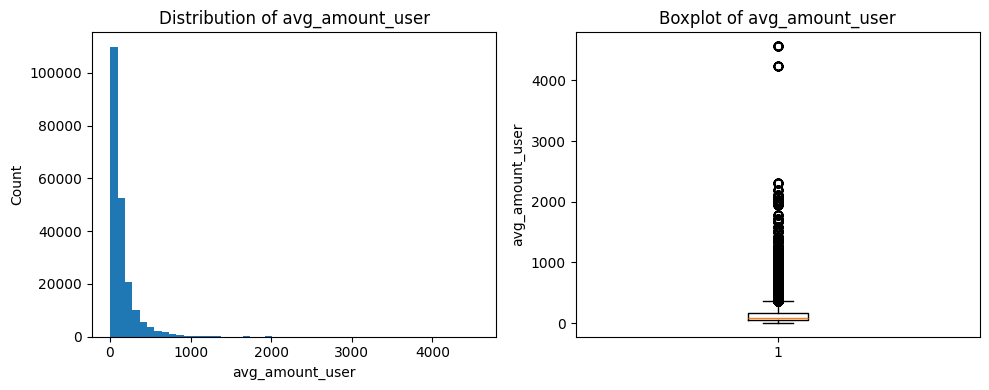

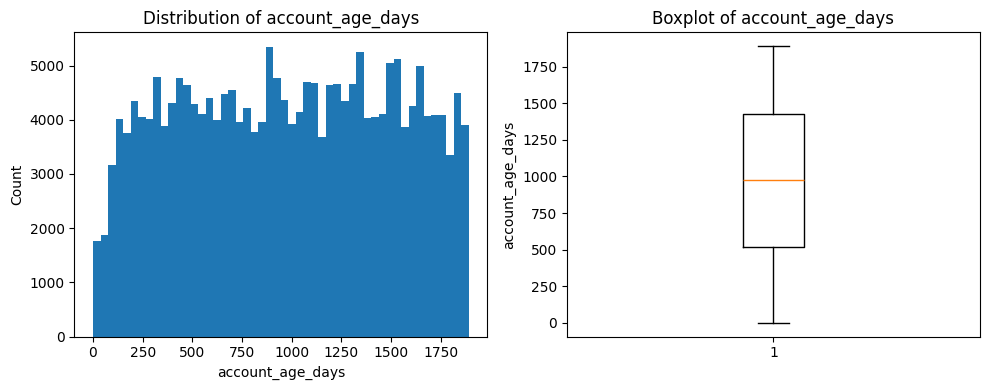

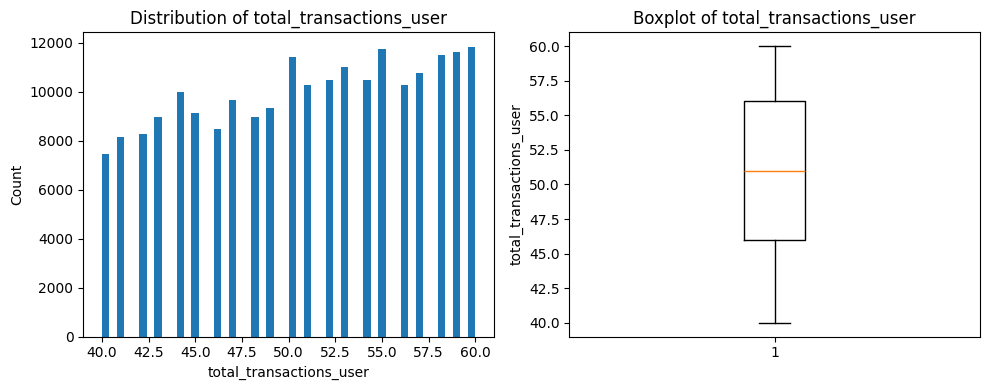

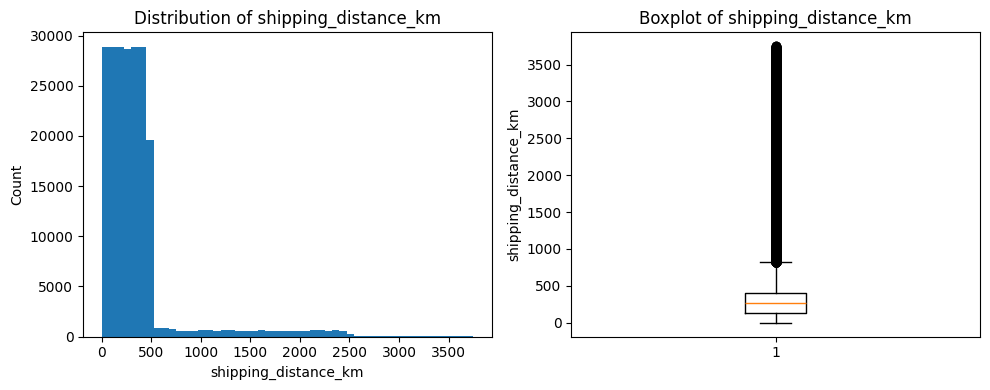

In [ ]:
NUMERIC_FEATURES = [
    "amount",
    "avg_amount_user",
    "account_age_days",
    "total_transactions_user",
    "shipping_distance_km",
]

for col in NUMERIC_FEATURES:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ----------------------------
    # Left: Histogram (distribution)
    # ----------------------------
    axes[0].hist(
        X_train_encoded[col].dropna(),
        bins=50,
    )
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Count")

    # ----------------------------
    # Right: Boxplot (outliers)
    # ----------------------------
    axes[1].boxplot(
        X_train_encoded[col].dropna(),
        vert=True,
        showfliers=True,
    )
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

In [18]:
# ============================================================
# Drop user_id from all feature splits
# ============================================================

ID_COLS = ["user_id"]

for df_split in (X_train_encoded, X_val_encoded, X_test_encoded):
    df_split.drop(columns=ID_COLS, inplace=True, errors="ignore")

In [26]:
# ============================================================
# Preprocessing pipeline 
# ============================================================

# ----------------------------
# Custom transformers
# ----------------------------
class QuantileClipper(BaseEstimator, TransformerMixin):
    """
    Clip each feature to [q_low, q_high] based on training quantiles.

    Using:
        - low/high quantiles to winsorize heavy tails.
        - Same clipping applied to val/test using train thresholds.
    """
    def __init__(self, low: float = 0.001, high: float = 0.999):
        if not 0.0 <= low < high <= 1.0:
            raise ValueError("low must be < high and in [0, 1].")
        self.low = low
        self.high = high

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q_low_ = np.nanquantile(X, self.low, axis=0)
        self.q_high_ = np.nanquantile(X, self.high, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.q_low_, self.q_high_)


class Log1pTransformer(BaseEstimator, TransformerMixin):
    """
    Apply np.log1p to positive features.

    Using:
        - log1p(x) = log(1 + x) to stabilize heavy-tailed distributions.
        - Assumes input values are >= 0.
    """
    def fit(self, X, y=None):
        # Stateless transformer.
        X = np.asarray(X, dtype=float)
        if (X < 0).any():
            raise ValueError("Log1pTransformer received negative values.")
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.log1p(X)


# ----------------------------
# Column groups
# ----------------------------
ALL_FEATURES: List[str] = list(X_train_encoded.columns)

# Heavy-tailed numeric features -> log1p + winsor + robust scale
LOG_NUM_COLS: List[str] = [
    "amount",
    "avg_amount_user",
    "shipping_distance_km",
]

# Remaining numeric features -> winsor + robust scale (no log)
LIN_NUM_COLS: List[str] = [
    "account_age_days",
    "total_transactions_user",
    "tx_month",
]

# Base binary features (already 0/1)
BASE_BINARY_COLS: List[str] = [
    "channel",
    "promo_used",
    "avs_match",
    "cvv_result",
    "three_ds_flag",
    "tx_is_weekend",
]

# One-hot encoded flags (also 0/1)
COUNTRY_OHE_COLS: List[str] = [c for c in ALL_FEATURES if c.startswith("country_")]
BIN_COUNTRY_OHE_COLS: List[str] = [c for c in ALL_FEATURES if c.startswith("bin_country_")]
MCAT_OHE_COLS: List[str] = [c for c in ALL_FEATURES if c.startswith("merchant_category_")]

BINARY_COLS: List[str] = (
    BASE_BINARY_COLS
    + COUNTRY_OHE_COLS
    + BIN_COUNTRY_OHE_COLS
    + MCAT_OHE_COLS
)

# Cyclic datetime features (already in [-1, 1])
CYCLIC_COLS: List[str] = [
    "tx_hour_sin",
    "tx_hour_cos",
    "tx_dow_sin",
    "tx_dow_cos",
]

# ----------------------------
# Build ColumnTransformer
# ----------------------------

log_num_pipe = Pipeline(
    steps=[
        ("log1p", Log1pTransformer()),
        ("winsor", QuantileClipper(low=0.001, high=0.999)),
        ("scaler", RobustScaler()),
    ]
)

lin_num_pipe = Pipeline(
    steps=[
        ("winsor", QuantileClipper(low=0.001, high=0.999)),
        ("scaler", RobustScaler()),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("log_num", log_num_pipe, LOG_NUM_COLS),
        ("lin_num", lin_num_pipe, LIN_NUM_COLS),
        ("binary", "passthrough", BINARY_COLS),
        ("cyclic", "passthrough", CYCLIC_COLS),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ----------------------------
# Fit on train, transform all splits
# ----------------------------
X_train_processed = preprocess.fit_transform(X_train_encoded)
X_val_processed = preprocess.transform(X_val_encoded)
X_test_processed = preprocess.transform(X_test_encoded)

print("Preprocessed feature shapes (with log1p on heavy-tailed):")
print(f"  X_train_processed: {X_train_processed.shape}")
print(f"  X_val_processed:   {X_val_processed.shape}")
print(f"  X_test_processed:  {X_test_processed.shape}")


Preprocessed feature shapes (with log1p on heavy-tailed):
  X_train_processed: (209785, 41)
  X_val_processed:   (44955, 41)
  X_test_processed:  (44955, 41)
